# EDA

In [4]:
import os
mao_sentences = []
for root, dirs, files in os.walk("../mao"):
    for file in files:
        if file.endswith(".txt"):
            print(os.path.join(root, file))
            with open(os.path.join(root, file), "r") as input:
                sentences = input.read().split(". ")   #. denotes end of sentence
            mao_sentences.extend(sentences)
            
print(len(mao_sentences))
print(mao_sentences[0])

../mao/REPORT ON AN INVESTIGATION OF THE PEASANT MOVEMENT IN HUNAN.txt
../mao/WHY IS IT THAT RED POLITICAL POWER CAN EXIST IN CHINA.txt
../mao/ANALYSIS OF THE CLASSES IN CHINESE SOCIETY.txt
../mao/ON CORRECTING MISTAKEN IDEAS IN THE PARTY.txt
../mao/A SINGLE SPARK CAN START A PRAIRIE FIRE.txt
../mao/BE CONCERNED WITH THE WELL-BEING OF THE MASSES, PAY ATTENTION TO METHODS OF WORK.txt
966
THE IMPORTANCE OF THE PEASANT PROBLEM
During my recent visit to Hunan [1] I made a first-hand investigation of conditions in the five counties of Hsiangtan, Hsianghsiang, Hengshan, Liling and Changsha


In [5]:
import numpy as np
import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

mao_df = pd.DataFrame(mao_sentences, columns = ['Sentence'])
mao_df.head()

,Sentence
0,THE IMPORTANCE OF THE PEASANT PROBLEM\nDuring ...
1,In the thirty-two days from January 4 to Febru...
2,Many of the hows and whys of the peasant movem...
3,I saw and heard of many strange things of whic...
4,I believe the same is true of many other place...


Text(0.5, 1.0, 'Distribution of number of words in each sentence')

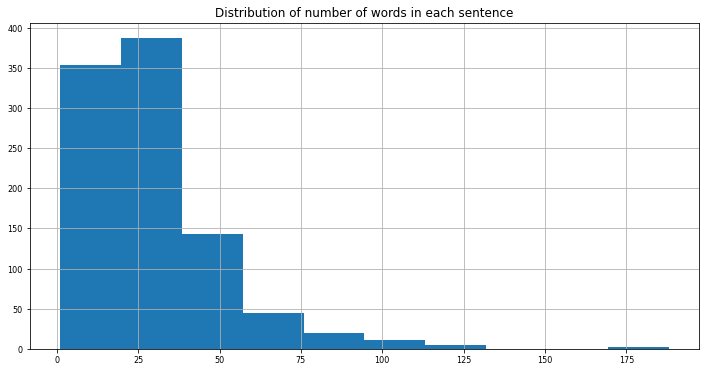

In [6]:
mao_df['NumWords'] = mao_df['Sentence'].apply(lambda x: len(x.split()))
mao_df[['NumWords']].hist(figsize=(12, 6), bins=10, xlabelsize=8, ylabelsize=8);
plt.title("Distribution of number of words in each sentence")

Let's do some cleaning operations like turning all words to lowercase, remove punctuation and non-ASCII characters which are irrelevant for modeling topics.

In [7]:
import re
NON_ALPHANUM = re.compile(r'[\W]')
NON_ASCII = re.compile(r'[^a-z0-1\s]')
def normalize_texts(texts):
    normalized_texts = ''
    lower = texts.lower()
    no_punctuation = NON_ALPHANUM.sub(r' ', lower)
    no_non_ascii = NON_ASCII.sub(r'', no_punctuation)
    return no_non_ascii
  
mao_df['Sentence2'] = mao_df['Sentence'].apply(normalize_texts)
mao_df.head()
mao_df['Sentence2'] = mao_df['Sentence2'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

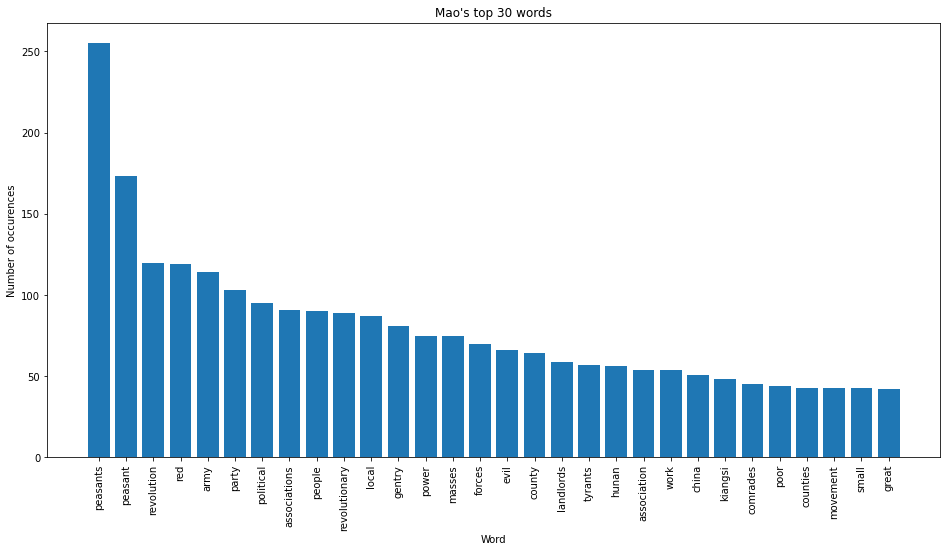

In [8]:
def get_top_n_words(corpus, n=10):
    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in   vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

words = []
word_values = []
for i,j in get_top_n_words(mao_df['Sentence2'], 30):
    words.append(i)
    word_values.append(j)
fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title("Mao's top 30 words");
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

# Sentence Embedding

In [9]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('stsb-roberta-large')

In [10]:
mao_df.head()

,Sentence,NumWords,Sentence2
0,THE IMPORTANCE OF THE PEASANT PROBLEM\nDuring ...,31,the importance the peasant problem during rece...
1,In the thirty-two days from January 4 to Febru...,48,the thirty two days from january february call...
2,Many of the hows and whys of the peasant movem...,24,many the hows and whys the peasant movement we...
3,I saw and heard of many strange things of whic...,15,saw and heard many strange things which had hi...
4,I believe the same is true of many other place...,11,believe the same true many other places too


In [11]:
sentence_embeddings = model.encode(mao_df.Sentence2)
sentence_embeddings.shape

(966, 1024)

# Kmeans

Try to find the best k, let us try to use `Elbow Method` and `Silhouette Coefficient`

#### 1. Elbow Method

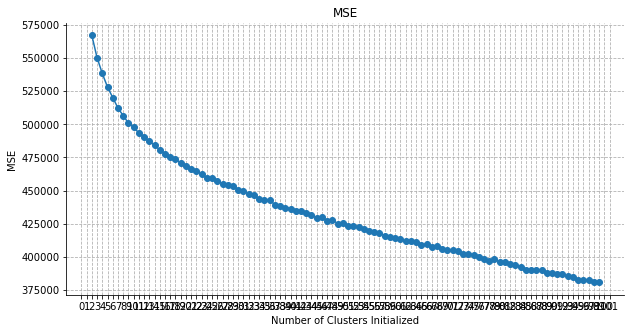

In [20]:
MSE = []  # store mean square error
for k in range(2,100):
    km = KMeans(n_clusters=k) 
    km.fit(sentence_embeddings)
    MSE.append(km.inertia_)
# inertia_:Sum of squared distances of samples to their closest cluster center.
plt.figure(figsize=(10,5))   
plt.plot(range(2,100),MSE,'o-')
plt.xticks(range(0,102,1)) 
plt.grid(linestyle='--')
plt.xlabel("Number of Clusters Initialized")
plt.ylabel('MSE')
plt.title("MSE")
sns.despine()

#### 2. Silhouette Coefficient
https://en.wikipedia.org/wiki/Silhouette_(clustering)   

-1<=Si<=1   
The clusting performance is better when the Silhouette Coefficient is close to 1

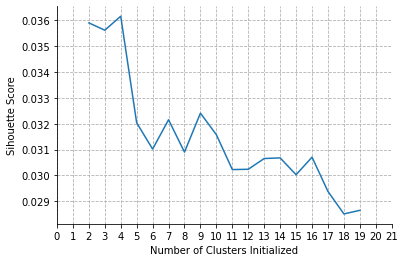

In [21]:
from sklearn import metrics

scores = []
for k in range(2,20):
    labels = KMeans(n_clusters=k).fit(sentence_embeddings).labels_
    score = metrics.silhouette_score(sentence_embeddings, labels)
    scores.append(score)

plt.plot(list(range(2,20)),scores)
plt.xticks(range(0,22,1)) 
plt.grid(linestyle='--')
plt.xlabel("Number of Clusters Initialized")
plt.ylabel("Sihouette Score")
sns.despine()

## 4 cluster Kmeans

In [22]:
from sklearn.cluster import KMeans
km = KMeans(
    n_clusters=4, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)
y_km = km.fit_predict(sentence_embeddings)
df = pd.DataFrame({'mao': mao_sentences, 'topic_cluster': y_km })

In [23]:
df.head()

,mao,topic_cluster
0,THE IMPORTANCE OF THE PEASANT PROBLEM\nDuring ...,0
1,In the thirty-two days from January 4 to Febru...,0
2,Many of the hows and whys of the peasant movem...,0
3,I saw and heard of many strange things of whic...,2
4,I believe the same is true of many other place...,2


In [24]:
df.loc[df['topic_cluster'] == 0].head()

,mao,topic_cluster
0,THE IMPORTANCE OF THE PEASANT PROBLEM\nDuring ...,0
1,In the thirty-two days from January 4 to Febru...,0
2,Many of the hows and whys of the peasant movem...,0
5,All talk directed against the peasant movement...,0
6,All the wrong measures taken by the revolution...,0


In [25]:
df.loc[df['topic_cluster'] == 1].head()

,mao,topic_cluster
7,Only thus can the future of the revolution be ...,1
9,"In a very short time, in China's central, sout...",1
10,They will smash all the trammels that bind the...,1
14,To march at their head and lead them? To trail...,1
25,In force and momentum the attack is tempestuou...,1


In [26]:
df.loc[df['topic_cluster'] == 2].head()

,mao,topic_cluster
3,I saw and heard of many strange things of whic...,2
4,I believe the same is true of many other place...,2
13,There are three alternatives,2
15,"The first, from January to September of last y...",2
19,"The second period, from last October to Januar...",2


In [27]:
df.loc[df['topic_cluster'] == 3].head()

,mao,topic_cluster
12,Every revolutionary party and every revolution...,3
16,"In this period, January to June was a time of ...",3
17,"During this period, the membership of the peas...",3
32,Those who are outside the associations can onl...,3
33,"The local tyrants, evil gentry and lawless lan...",3


In [28]:
centers = km.cluster_centers_
centers

array([[-0.19169827,  0.71000564,  0.02962296, ...,  0.8753664 ,
        -0.9336492 ,  0.3572775 ],
       [ 0.16028629,  0.7491212 ,  0.06457952, ...,  0.85145175,
        -0.88186264,  0.38041458],
       [-0.23224005,  0.2044101 , -0.03319081, ...,  0.22243887,
        -0.8142992 ,  0.52056485],
       [-0.08993327,  0.35704657, -0.03931243, ...,  0.37524527,
        -0.59404796,  0.5344189 ]], dtype=float32)

Select a sentence which is cloest to each group center

In [70]:
def select_center_sentence(group_id):
    distance =[]
    # get one group sentence embeddings
    group_sentence_embeddings = sentence_embeddings[df['topic_cluster'] == group_id]
    print('there are %d sentences in group %d'%(len(group_sentence_embeddings),group_id))
    for sentence in group_sentence_embeddings:
        dis = 0
        for index in range(len(sentence)):
            # calculate the distance between this sentence and group center
            dis = dis + (sentence[index] - centers[group_id][index])**2
        distance.append(dis)
    
    # get the min distance's index
    min_index = distance.index(min(distance))
    df_group = df.loc[df['topic_cluster'] == group_id]
    df_group = df_group.reset_index(drop=True)
    return df_group.mao[min_index]

In [71]:
group0_belief = select_center_sentence(group_id = 0)
group0_belief

there are 301 sentences in group 0


'[5] Those who talk about the peasants "going too far" seem at first sight to be different from those who say "It\'s terrible!" as mentioned earlier, but in essence they proceed from the same standpoint and likewise voice a landlord theory that upholds the interests of the privileged classes'

In [72]:
group1_belief = select_center_sentence(group_id = 1)
group1_belief

there are 212 sentences in group 1


'The prolonged splits and wars within the White regime provide a condition for the emergence and persistence of one or more small Red areas under the leadership of the Communist Party amidst the encirclement of the White regime'

In [73]:
group2_belief = select_center_sentence(group_id = 2)
group2_belief

there are 234 sentences in group 2


'Pleasure-seeking'

In [74]:
group3_belief = select_center_sentence(group_id = 3)
group3_belief

there are 219 sentences in group 3


'But more often than not they are turned down flat, and so they are always on tenderhooks; with the doors of the association barred to them, they are like tramps without a home or, in rural parlance, "mere trash"'

## T-SNE
Reduce dimensions and visualize the result

In [76]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=1000, verbose=1, random_state=0, angle=0.75)
tsne_features = model.fit_transform(sentence_embeddings)
tsne_features

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 966 samples in 0.049s...
[t-SNE] Computed neighbors for 966 samples in 1.733s...
[t-SNE] Computed conditional probabilities for sample 966 / 966
[t-SNE] Mean sigma: 8.433334
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.655289
[t-SNE] KL divergence after 1000 iterations: 1.628647


array([[ -1.1614051,  17.886862 ],
       [  4.185662 ,  19.255346 ],
       [ 10.376097 , -19.558    ],
       ...,
       [  8.4731   , -13.896269 ],
       [ -7.8072686,   2.0351307],
       [  5.137654 ,  -2.162219 ]], dtype=float32)

In [78]:
df_tsne = pd.DataFrame(tsne_features)
df_tsne['topic'] = df.topic_cluster
df_tsne.columns = ['TSNE1', 'TSNE2', 'topic']
df_tsne

,TSNE1,TSNE2,topic
0,-1.161405,17.886862,0
1,4.185662,19.255346,0
2,10.376097,-19.558001,0
3,9.075850,-23.278318,2
4,0.237779,-26.056753,2
...,...,...,...
961,-10.335762,3.289587,1
962,-13.079557,-5.429315,1
963,8.473100,-13.896269,2
964,-7.807269,2.035131,2


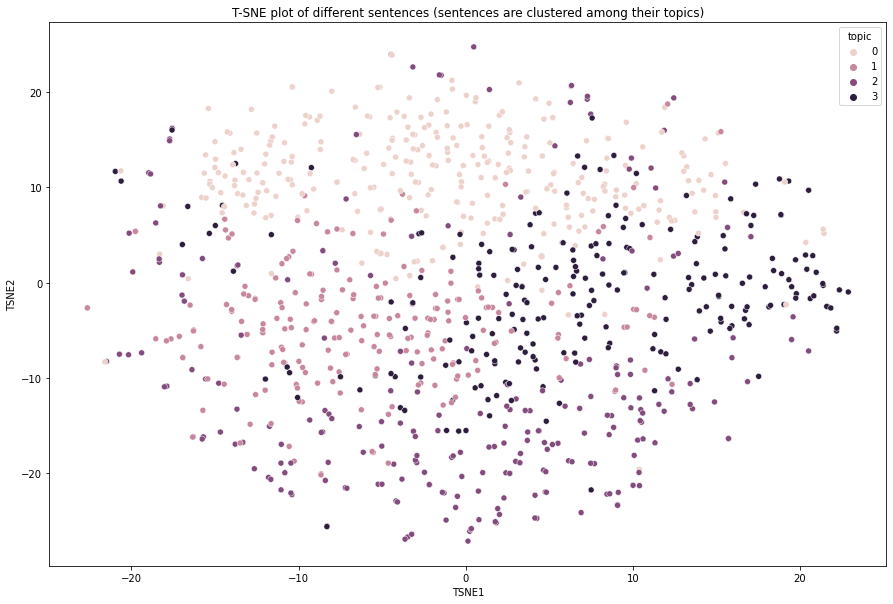

In [79]:
import seaborn as sns
plt.figure(figsize=(15, 10))
plt.title('T-SNE plot of different sentences (sentences are clustered among their topics)')
ax = sns.scatterplot(x = 'TSNE1', y = 'TSNE2', hue = 'topic', data = df_tsne, legend = 'full')
plt.show()